## Pitch detection

In [1]:
import argparse
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2
import torch
from tqdm import tqdm
import torch
import numpy as np
import supervision as sv
from tqdm import tqdm
from transformers import AutoProcessor, SiglipVisionModel
import umap.umap_ as umap
from sklearn.cluster import KMeans
from typing import Generator, Iterable, List, TypeVar
from ultralytics import YOLO
from typing import Optional, List

In [2]:
model_path_pitch_detection = "../models/yolov8x_pitch_detection.pt"
PITCH_DETECTION_MODEL = YOLO(model_path_pitch_detection)
model_player_detection = "../models/yolov8x_transfer_based_model.pt"
PLAYER_DETECTION_MODEL = YOLO(model_player_detection)
SOURCE_VIDEO_PATH = "../test_videos/121364_0.mp4"


0: 384x640 1 pitch, 118.4ms
Speed: 3.4ms preprocess, 118.4ms inference, 101.1ms postprocess per image at shape (1, 3, 384, 640)


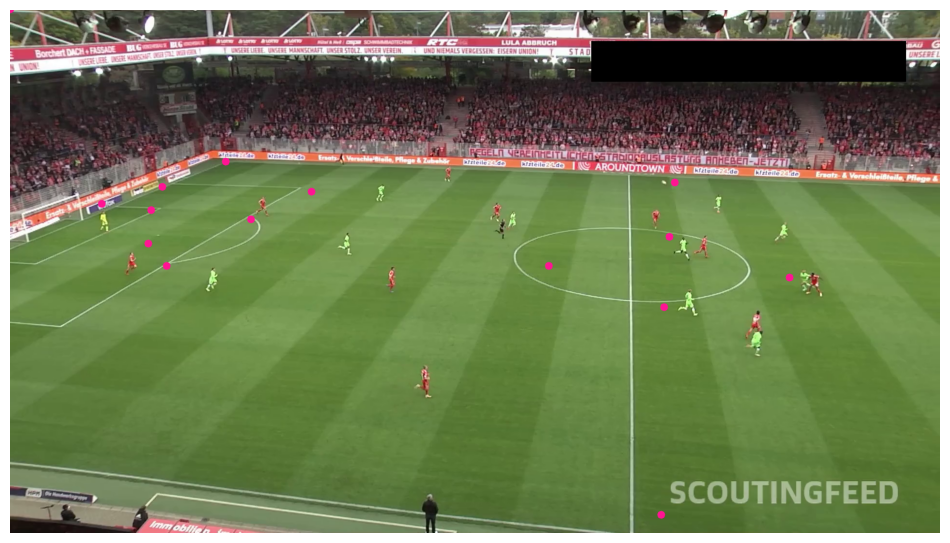

In [3]:
vertex_annotator = sv.VertexAnnotator(
    color = sv.Color.from_hex("#FF1493"),
    radius = 8
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PITCH_DETECTION_MODEL(frame, conf = 0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy = frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, key_points)

sv.plot_image(annotated_frame)

## Pitch lines on frame

In [4]:
from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

In [7]:
CONFIG = SoccerPitchConfiguration()
CONFIG.vertices

[(0, 0),
 (0, 1450.0),
 (0, 2584.0),
 (0, 4416.0),
 (0, 5550.0),
 (0, 7000),
 (550, 2584.0),
 (550, 4416.0),
 (1100, 3500.0),
 (2015, 1450.0),
 (2015, 2584.0),
 (2015, 4416.0),
 (2015, 5550.0),
 (6000.0, 0),
 (6000.0, 2585.0),
 (6000.0, 4415.0),
 (6000.0, 7000),
 (9985, 1450.0),
 (9985, 2584.0),
 (9985, 4416.0),
 (9985, 5550.0),
 (10900, 3500.0),
 (11450, 2584.0),
 (11450, 4416.0),
 (12000, 0),
 (12000, 1450.0),
 (12000, 2584.0),
 (12000, 4416.0),
 (12000, 5550.0),
 (12000, 7000),
 (5085.0, 3500.0),
 (6915.0, 3500.0)]

In [8]:
CONFIG.edges

[(1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (7, 8),
 (10, 11),
 (11, 12),
 (12, 13),
 (14, 15),
 (15, 16),
 (16, 17),
 (18, 19),
 (19, 20),
 (20, 21),
 (23, 24),
 (25, 26),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (1, 14),
 (2, 10),
 (3, 7),
 (4, 8),
 (5, 13),
 (6, 17),
 (14, 25),
 (18, 26),
 (23, 27),
 (24, 28),
 (21, 29),
 (17, 30)]

In [9]:
def draw_pitch(
    config: SoccerPitchConfiguration,
    background_color: sv.Color = sv.Color(34, 139, 34),
    line_color: sv.Color = sv.Color.WHITE,
    padding: int = 50,
    line_thickness: int = 4,
    point_radius: int = 8,
    scale: float = 0.1
) -> np.ndarray:
    """
    Draws a soccer pitch with specified dimensions, colors, and scale.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        background_color (sv.Color, optional): Color of the pitch background.
            Defaults to sv.Color(34, 139, 34).
        line_color (sv.Color, optional): Color of the pitch lines.
            Defaults to sv.Color.WHITE.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        line_thickness (int, optional): Thickness of the pitch lines in pixels.
            Defaults to 4.
        point_radius (int, optional): Radius of the penalty spot points in pixels.
            Defaults to 8.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.

    Returns:
        np.ndarray: Image of the soccer pitch.
    """
    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)
    scaled_circle_radius = int(config.centre_circle_radius * scale)
    scaled_penalty_spot_distance = int(config.penalty_spot_distance * scale)

    pitch_image = np.ones(
        (scaled_width + 2 * padding,
         scaled_length + 2 * padding, 3),
        dtype=np.uint8
    ) * np.array(background_color.as_bgr(), dtype=np.uint8)

    for start, end in config.edges:
        point1 = (int(config.vertices[start - 1][0] * scale) + padding,
                  int(config.vertices[start - 1][1] * scale) + padding)
        point2 = (int(config.vertices[end - 1][0] * scale) + padding,
                  int(config.vertices[end - 1][1] * scale) + padding)
        cv2.line(
            img=pitch_image,
            pt1=point1,
            pt2=point2,
            color=line_color.as_bgr(),
            thickness=line_thickness
        )

    centre_circle_center = (
        scaled_length // 2 + padding,
        scaled_width // 2 + padding
    )
    cv2.circle(
        img=pitch_image,
        center=centre_circle_center,
        radius=scaled_circle_radius,
        color=line_color.as_bgr(),
        thickness=line_thickness
    )

    penalty_spots = [
        (
            scaled_penalty_spot_distance + padding,
            scaled_width // 2 + padding
        ),
        (
            scaled_length - scaled_penalty_spot_distance + padding,
            scaled_width // 2 + padding
        )
    ]
    for spot in penalty_spots:
        cv2.circle(
            img=pitch_image,
            center=spot,
            radius=point_radius,
            color=line_color.as_bgr(),
            thickness=-1
        )

    return pitch_image


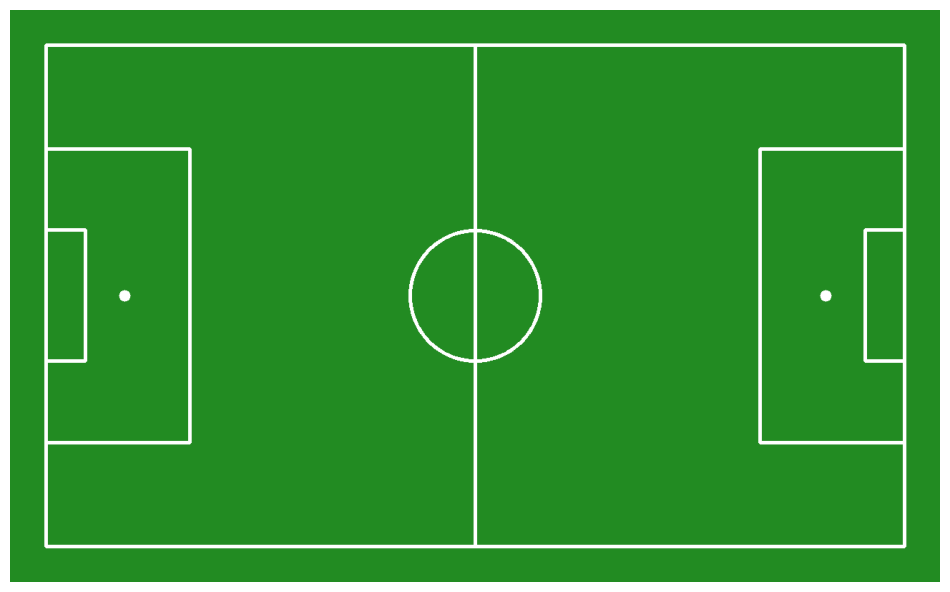

In [10]:
annotated_frame = draw_pitch(CONFIG)
sv.plot_image(annotated_frame)

In [21]:
from typing import Tuple
import cv2
import numpy as np
import numpy.typing as npt


class ViewTransformer:
    def __init__(
            self,
            source: npt.NDArray[np.float32],
            target: npt.NDArray[np.float32]
    ) -> None:

        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    def transform_points(
            self,
            points: npt.NDArray[np.float32]
    ) -> npt.NDArray[np.float32]:
        if len(points) > 0:
            points = points.reshape(-1, 1, 2).astype(np.float32)
            points = cv2.perspectiveTransform(points, self.m)
            return points.reshape(-1, 2).astype(np.float32)
        else:
            return []



0: 384x640 1 pitch, 108.0ms
Speed: 6.4ms preprocess, 108.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


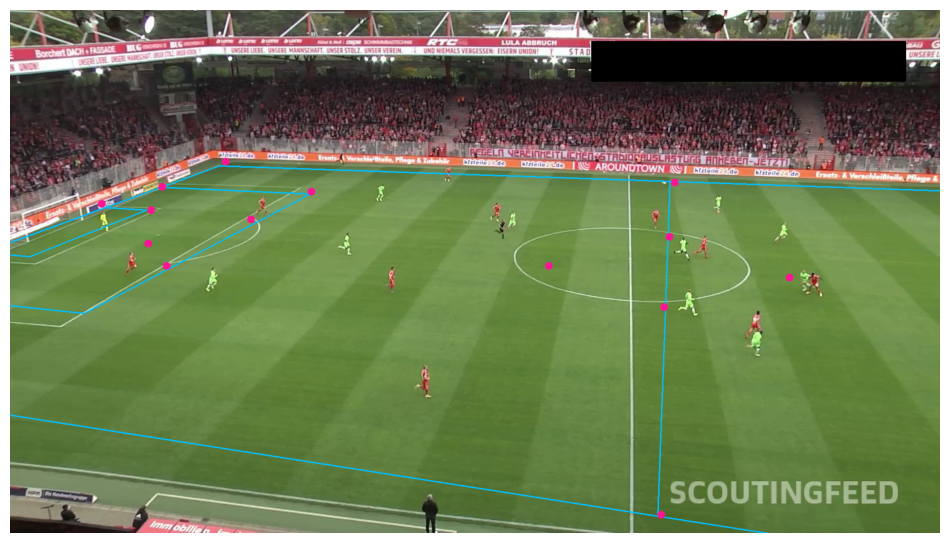

In [22]:
vertex_annotator = sv.VertexAnnotator(
    color = sv.Color.from_hex("#FF1493"),
    radius = 8
)
edge_annotator = sv.EdgeAnnotator(
    color = sv.Color.from_hex("00BFFF"),
    thickness=2,
    edges=CONFIG.edges
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PITCH_DETECTION_MODEL(frame, conf = 0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy = frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)

sv.plot_image(annotated_frame)

In [12]:
def extract_crops(model, source_video_path: str, stride: int = 30) -> List[np.ndarray]:
    """
    Extracts image crops of players from video frames using a YOLO model.

    Parameters:
    model (str or YOLO): The YOLO model or its path to detect objects in the video.
    source_video_path (str): Path to the source video file.
    stride (int): The number of frames to skip between detections. Default is 30.

    Returns:
    List[np.ndarray]: A list of image crops (NumPy arrays) containing detected players.
    """
    # Initialize the YOLO model
    model = YOLO(model)

    # Generate video frames from the source video with the specified stride
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=stride)

    crops = []
    # Iterate over each frame in the video
    for frame in tqdm(frame_generator):
        # Detect objects in the frame using the YOLO model
        result = model(frame, conf=0.3)[0]
        # Convert YOLO detections to a format usable by the supervision library
        detections = sv.Detections.from_ultralytics(result)
        # Apply non-maximum suppression (NMS) to filter overlapping detections
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        # Select only the detections corresponding to players (class_id = 2)
        detections = detections[detections.class_id == 2]

        # Extract and store crops of detected players from the frame
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ]
    return crops


In [13]:
def resolve_goalkeppers_team_id(player_detections: sv.Detections, goalkepper_detections: sv.Detections) -> np.ndarray:
    """
    Assigns team IDs to goalkeepers based on their proximity to the team's centroid.

    Parameters:
    player_detections (sv.Detections): Detections of all players in the scene.
    goalkepper_detections (sv.Detections): Detections of goalkeepers in the scene.

    Returns:
    np.ndarray: An array of team IDs assigned to each goalkeeper.
    """
    # Get the bottom-center coordinates of the goalkeepers and players
    goalkeppers_xy = goalkepper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    # Calculate the centroid of each team's players
    team_0_centroid = players_xy[player_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[player_detections.class_id == 1].mean(axis=0)

    goalkeppers_team_ids = []
    # Assign team IDs to each goalkeeper based on which team centroid is closer
    for goalkepper_xy in goalkeppers_xy:
        dist_0 = np.linalg.norm(goalkepper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkepper_xy - team_1_centroid)
        goalkeppers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeppers_team_ids)

In [14]:
class TeamClassifier:
    """
    A classifier to distinguish between different teams based on image crops using a vision model.
    """

    def __init__(self, batch_size: int = 32):
        """
        Initializes the TeamClassifier with a specified batch size and loads the required models.

        Parameters:
        batch_size (int): The number of images to process in a batch. Default is 32.
        """
        # Select device based on availability of GPU
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size

        # Load the pre-trained vision model and processor
        self.features_model = SiglipVisionModel.from_pretrained('google/siglip-base-patch16-224').to(self.device)
        self.processor = AutoProcessor.from_pretrained('google/siglip-base-patch16-224')

        # Initialize UMAP for dimensionality reduction and KMeans for clustering
        self.reducer = umap.UMAP(n_components=3)
        self.cluster_model = KMeans(n_clusters=2)

    def extract_features(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Extracts feature embeddings from image crops using the vision model.

        Parameters:
        crops (List[np.ndarray]): A list of image crops as NumPy arrays.

        Returns:
        np.ndarray: A NumPy array of feature embeddings.
        """
        # Convert the crops from OpenCV format to Pillow format
        crops = [sv.cv2_to_pillow(crop) for crop in crops]

        # Create batches of crops to process
        batches = create_batches(crops, self.batch_size)
        data = []

        # Disable gradient computation for inference
        with torch.no_grad():
            for batch in tqdm(batches):
                # Process the batch through the model
                inputs = self.processor(images=batch, return_tensors='pt').to(self.device)
                outputs = self.features_model(**inputs)

                # Compute mean embeddings for the batch
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)

        # Concatenate the embeddings of all batches into a single array
            return np.concatenate(data)



    def fit(self, crops: List[np.ndarray]) -> None:
        """
        Fits the classifier to the provided image crops by extracting features, reducing dimensions,
        and clustering the data.

        Parameters:
        crops (List[np.ndarray]): A list of image crops as NumPy arrays.
        """
        # Extract features from the crops
        data = self.extract_features(crops)

        # Reduce dimensions using UMAP
        projections = self.reducer.fit_transform(data)

        # Fit the KMeans clustering model to the reduced data
        self.cluster_model.fit(projections)

    def predict(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Predicts the team classification for the provided image crops.

        Parameters:
        crops (List[np.ndarray]): A list of image crops as NumPy arrays.

        Returns:
        np.ndarray: An array of predicted team labels.
        """
        if len(crops) == 0:
            return np.array([])

        # Extract features from the crops
        data = self.extract_features(crops)

        # Reduce dimensions using UMAP
        projections = self.reducer.transform(data)

        # Predict team labels using the trained clustering model
        return self.cluster_model.predict(projections)


In [15]:
V = TypeVar("V")
def create_batches(sequence: Iterable[V], batch_size: int) -> Generator[List[V], None, None]:
    """
    Splits an iterable sequence into smaller batches of a specified size.

    Parameters:
    sequence (Iterable[V]): The sequence to split into batches.
    batch_size (int): The number of elements per batch.

    Yields:
    Generator[List[V], None, None]: A generator yielding batches as lists of elements.
    """
    batch_size = max(batch_size, 1)  # Ensure batch_size is at least 1
    current_batch = []

    # Iterate through each element in the sequence
    for element in sequence:
        # Yield the batch when it reaches the specified size
        if len(current_batch) == batch_size:
            yield current_batch
            current_batch = []
        current_batch.append(element)

    # Yield any remaining elements in the last batch
    if current_batch:
        yield current_batch


In [16]:
def resolve_goalkeppers_team_id(player_detections: sv.Detections, goalkepper_detections: sv.Detections) -> np.ndarray:
    """
    Assigns team IDs to goalkeepers based on their proximity to the team's centroid.

    Parameters:
    player_detections (sv.Detections): Detections of all players in the scene.
    goalkepper_detections (sv.Detections): Detections of goalkeepers in the scene.

    Returns:
    np.ndarray: An array of team IDs assigned to each goalkeeper.
    """
    # Get the bottom-center coordinates of the goalkeepers and players
    goalkeppers_xy = goalkepper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    # Calculate the centroid of each team's players
    team_0_centroid = players_xy[player_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[player_detections.class_id == 1].mean(axis=0)

    goalkeppers_team_ids = []
    # Assign team IDs to each goalkeeper based on which team centroid is closer
    for goalkepper_xy in goalkeppers_xy:
        dist_0 = np.linalg.norm(goalkepper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkepper_xy - team_1_centroid)
        goalkeppers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeppers_team_ids)


In [17]:
def draw_paths_on_pitch(
    config: SoccerPitchConfiguration,
    paths: List[np.ndarray],
    color: sv.Color = sv.Color.WHITE,
    thickness: int = 2,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws paths on a soccer pitch.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        paths (List[np.ndarray]): List of paths, where each path is an array of (x, y)
            coordinates.
        color (sv.Color, optional): Color of the paths.
            Defaults to sv.Color.WHITE.
        thickness (int, optional): Thickness of the paths in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw paths on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with paths drawn on it.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    for path in paths:
        scaled_path = [
            (
                int(point[0] * scale) + padding,
                int(point[1] * scale) + padding
            )
            for point in path if point.size > 0
        ]

        if len(scaled_path) < 2:
            continue

        for i in range(len(scaled_path) - 1):
            cv2.line(
                img=pitch,
                pt1=scaled_path[i],
                pt2=scaled_path[i + 1],
                color=color.as_bgr(),
                thickness=thickness
            )

        return pitch

In [18]:
def draw_points_on_pitch(
    config: SoccerPitchConfiguration,
    xy: np.ndarray,
    face_color: sv.Color = sv.Color.RED,
    edge_color: sv.Color = sv.Color.BLACK,
    radius: int = 10,
    thickness: int = 2,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws points on a soccer pitch.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        xy (np.ndarray): Array of points to be drawn, with each point represented by
            its (x, y) coordinates.
        face_color (sv.Color, optional): Color of the point faces.
            Defaults to sv.Color.RED.
        edge_color (sv.Color, optional): Color of the point edges.
            Defaults to sv.Color.BLACK.
        radius (int, optional): Radius of the points in pixels.
            Defaults to 10.
        thickness (int, optional): Thickness of the point edges in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw points on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with points drawn on it.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    for point in xy:
        scaled_point = (
            int(point[0] * scale) + padding,
            int(point[1] * scale) + padding
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )

    return pitch


In [19]:
from PIL import Image
from IPython.display import display, clear_output
import supervision as sv

In [ ]:
SOURCE_VIDEO_PATH = "../test_videos/121364_0.mp4"
TARGET_VIDEO_PATH = "../result_videos/radar_view_result.mp4"
BALL_ID = 0
GOALKEPPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops("../models/yolov8x_transfer_based_model.pt", source_video_path=SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier()
team_classifier.fit(crops)

tracker = sv.ByteTrack()
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
tracker.reset()
with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in frames_generator:

        result = PLAYER_DETECTION_MODEL(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEPPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeppers_team_id(
            players_detections, goalkeepers_detections
        )

        result_pitch = PITCH_DETECTION_MODEL(frame, conf=0.3)[0]
        key_points = sv.KeyPoints.from_ultralytics(result_pitch)

        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        frame_reference_key_points = sv.KeyPoints(xy = frame_reference_points[np.newaxis, ...])
        pitch_reference_points = np.array(CONFIG.vertices)[filter]

        view_transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )

        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = view_transformer.transform_points(frame_players_xy)

        frame_referees_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

        pitch = draw_pitch(config=CONFIG)
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex("00BFFF"),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex("FF1493"),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex("FFD700"),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        sink.write_frame(frame=pitch)

0it [00:00, ?it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 301.8ms
Speed: 6.6ms preprocess, 301.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.42s/it]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.8ms
Speed: 6.8ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


2it [00:01,  1.22it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 302.7ms
Speed: 6.7ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


3it [00:02,  1.58it/s]


0: 736x1280 20 players, 2 referees, 302.3ms
Speed: 7.5ms preprocess, 302.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


4it [00:02,  1.85it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 303.8ms
Speed: 8.1ms preprocess, 303.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


5it [00:03,  2.03it/s]


0: 736x1280 1 ball, 23 players, 1 referee, 301.0ms
Speed: 7.0ms preprocess, 301.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


6it [00:03,  2.17it/s]


0: 736x1280 20 players, 2 referees, 300.2ms
Speed: 6.7ms preprocess, 300.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


7it [00:03,  2.26it/s]


0: 736x1280 1 ball, 19 players, 2 referees, 309.1ms
Speed: 8.0ms preprocess, 309.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


8it [00:04,  2.32it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 306.2ms
Speed: 7.0ms preprocess, 306.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


9it [00:04,  2.36it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.7ms
Speed: 6.2ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


10it [00:05,  2.38it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.6ms
Speed: 6.7ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


11it [00:05,  2.40it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.8ms
Speed: 6.8ms preprocess, 303.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


12it [00:05,  2.40it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 308.6ms
Speed: 7.3ms preprocess, 308.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


13it [00:06,  2.40it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.5ms
Speed: 6.1ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


14it [00:06,  2.42it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 300.8ms
Speed: 7.2ms preprocess, 300.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


15it [00:07,  2.44it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 301.1ms
Speed: 6.6ms preprocess, 301.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


16it [00:07,  2.43it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.6ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


17it [00:07,  2.44it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 303.1ms
Speed: 7.6ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


18it [00:08,  2.44it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 303.4ms
Speed: 6.6ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


19it [00:08,  2.44it/s]


0: 736x1280 1 goalkeeper, 19 players, 1 referee, 304.6ms
Speed: 10.6ms preprocess, 304.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


20it [00:09,  2.44it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 301.6ms
Speed: 6.5ms preprocess, 301.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


21it [00:09,  2.43it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.9ms
Speed: 7.1ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


22it [00:09,  2.45it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.1ms
Speed: 6.7ms preprocess, 302.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


23it [00:10,  2.44it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 302.5ms
Speed: 6.8ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


24it [00:10,  2.46it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 302.8ms
Speed: 6.8ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


25it [00:11,  2.22it/s]
16it [00:17,  1.10s/it]



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 313.4ms
Speed: 9.5ms preprocess, 313.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.5ms
Speed: 6.4ms preprocess, 305.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 303.0ms
Speed: 7.4ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 2.3ms preprocess, 101.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 304.5ms
Speed: 7.1ms preprocess, 304.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 105.3ms
Speed: 1.7ms preprocess, 105.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 311.8ms
Speed: 6.4ms preprocess, 311.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 301.7ms
Speed: 7.0ms preprocess, 301.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.5ms
Speed: 6.2ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.9ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.7ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 302.1ms
Speed: 6.1ms preprocess, 302.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.7ms
Speed: 1.7ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 303.6ms
Speed: 6.6ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.4ms
Speed: 1.9ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 304.3ms
Speed: 6.6ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 304.5ms
Speed: 6.0ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 304.3ms
Speed: 6.6ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 304.9ms
Speed: 6.7ms preprocess, 304.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.01it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 302.9ms
Speed: 6.7ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.01it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 302.0ms
Speed: 6.7ms preprocess, 302.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 301.3ms
Speed: 6.4ms preprocess, 301.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 309.4ms
Speed: 6.5ms preprocess, 309.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.7ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 303.0ms
Speed: 6.4ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.00it/s]



0: 384x640 1 pitch, 102.1ms
Speed: 1.8ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 303.7ms
Speed: 6.7ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.00it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 301.1ms
Speed: 6.5ms preprocess, 301.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 102.1ms
Speed: 1.8ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 305.4ms
Speed: 6.2ms preprocess, 305.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.06it/s]



0: 384x640 1 pitch, 107.1ms
Speed: 1.7ms preprocess, 107.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 1 referee, 315.5ms
Speed: 6.3ms preprocess, 315.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.02it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.9ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 302.6ms
Speed: 6.1ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 303.1ms
Speed: 6.1ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.4ms
Speed: 1.9ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.5ms
Speed: 6.9ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 2.8ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.6ms
Speed: 6.2ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 304.9ms
Speed: 6.7ms preprocess, 304.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 301.9ms
Speed: 6.5ms preprocess, 301.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.5ms
Speed: 6.5ms preprocess, 304.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 106.1ms
Speed: 1.8ms preprocess, 106.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 308.2ms
Speed: 6.2ms preprocess, 308.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.4ms
Speed: 6.2ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.7ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 6.3ms preprocess, 305.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.26it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.9ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.5ms
Speed: 7.0ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 308.9ms
Speed: 7.1ms preprocess, 308.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 6.1ms preprocess, 305.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.7ms preprocess, 100.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.7ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.2ms
Speed: 6.8ms preprocess, 304.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.8ms
Speed: 1.8ms preprocess, 101.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.5ms
Speed: 6.0ms preprocess, 303.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 301.8ms
Speed: 7.0ms preprocess, 301.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.9ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.3ms
Speed: 6.9ms preprocess, 302.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.7ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.3ms
Speed: 6.2ms preprocess, 305.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.24it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 303.6ms
Speed: 7.0ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.31it/s]



0: 384x640 1 pitch, 103.2ms
Speed: 1.9ms preprocess, 103.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 302.9ms
Speed: 6.9ms preprocess, 302.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.3ms
Speed: 6.5ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 102.9ms
Speed: 1.9ms preprocess, 102.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 306.0ms
Speed: 6.3ms preprocess, 306.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.8ms
Speed: 2.0ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.3ms
Speed: 6.4ms preprocess, 302.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 102.0ms
Speed: 1.7ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 301.9ms
Speed: 6.4ms preprocess, 301.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.5ms
Speed: 6.2ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.4ms
Speed: 6.8ms preprocess, 302.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.2ms
Speed: 6.5ms preprocess, 304.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 302.7ms
Speed: 6.5ms preprocess, 302.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.01it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 301.0ms
Speed: 5.9ms preprocess, 301.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.7ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.9ms
Speed: 6.5ms preprocess, 304.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.7ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.4ms
Speed: 6.1ms preprocess, 302.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 301.7ms
Speed: 7.4ms preprocess, 301.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.8ms
Speed: 1.7ms preprocess, 101.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.7ms
Speed: 6.8ms preprocess, 303.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.9ms
Speed: 6.7ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 305.1ms
Speed: 6.5ms preprocess, 305.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.00it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 303.6ms
Speed: 6.7ms preprocess, 303.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 302.0ms
Speed: 6.6ms preprocess, 302.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.8ms
Speed: 6.9ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.7ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 303.6ms
Speed: 6.8ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 102.2ms
Speed: 1.8ms preprocess, 102.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 305.2ms
Speed: 6.7ms preprocess, 305.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 304.1ms
Speed: 6.6ms preprocess, 304.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 303.7ms
Speed: 6.3ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 306.7ms
Speed: 6.7ms preprocess, 306.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.03it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 22 players, 3 referees, 303.6ms
Speed: 6.6ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 22 players, 1 referee, 304.4ms
Speed: 6.8ms preprocess, 304.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 304.0ms
Speed: 6.5ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 2.1ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 302.2ms
Speed: 6.8ms preprocess, 302.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 3 referees, 302.2ms
Speed: 6.5ms preprocess, 302.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 301.5ms
Speed: 6.7ms preprocess, 301.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 103.9ms
Speed: 1.8ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 308.7ms
Speed: 7.0ms preprocess, 308.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.27it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.9ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 302.5ms
Speed: 6.2ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.03it/s]



0: 384x640 1 pitch, 108.0ms
Speed: 1.9ms preprocess, 108.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 312.4ms
Speed: 6.8ms preprocess, 312.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.30it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 304.3ms
Speed: 6.3ms preprocess, 304.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 304.6ms
Speed: 6.8ms preprocess, 304.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 303.2ms
Speed: 6.3ms preprocess, 303.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.7ms
Speed: 6.6ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.9ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.3ms
Speed: 6.5ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 306.3ms
Speed: 6.6ms preprocess, 306.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.2ms
Speed: 6.1ms preprocess, 304.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 1 referee, 304.5ms
Speed: 6.7ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.4ms
Speed: 1.9ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 22 players, 1 referee, 301.0ms
Speed: 6.2ms preprocess, 301.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.01it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 301.2ms
Speed: 6.8ms preprocess, 301.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.2ms
Speed: 6.3ms preprocess, 304.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.7ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 302.6ms
Speed: 6.8ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 1 referee, 303.1ms
Speed: 6.5ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.6ms
Speed: 1.7ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 304.8ms
Speed: 6.3ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.6ms
Speed: 2.2ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 305.4ms
Speed: 6.7ms preprocess, 305.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 22 players, 2 referees, 302.8ms
Speed: 6.2ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 22 players, 2 referees, 304.1ms
Speed: 6.2ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.8ms
Speed: 6.2ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 308.5ms
Speed: 10.8ms preprocess, 308.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.3ms
Speed: 6.8ms preprocess, 303.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 307.9ms
Speed: 7.1ms preprocess, 307.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.8ms
Speed: 6.9ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.5ms
Speed: 6.1ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.1ms
Speed: 7.1ms preprocess, 305.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.9ms
Speed: 6.0ms preprocess, 302.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.7ms
Speed: 6.5ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.9ms
Speed: 6.3ms preprocess, 302.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.7ms
Speed: 6.3ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.8ms
Speed: 6.3ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.2ms
Speed: 6.3ms preprocess, 305.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 301.7ms
Speed: 7.1ms preprocess, 301.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.6ms
Speed: 6.1ms preprocess, 304.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.7ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 305.1ms
Speed: 6.5ms preprocess, 305.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 306.5ms
Speed: 6.8ms preprocess, 306.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.1ms
Speed: 6.1ms preprocess, 302.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.1ms
Speed: 6.2ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 305.4ms
Speed: 6.2ms preprocess, 305.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.7ms
Speed: 6.4ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.9ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 303.9ms
Speed: 6.4ms preprocess, 303.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.7ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 305.7ms
Speed: 6.3ms preprocess, 305.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.9ms
Speed: 6.6ms preprocess, 304.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 305.0ms
Speed: 6.7ms preprocess, 305.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.8ms
Speed: 6.5ms preprocess, 303.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.7ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.1ms
Speed: 6.5ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.9ms
Speed: 6.6ms preprocess, 304.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.5ms
Speed: 6.6ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 303.4ms
Speed: 6.4ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.7ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.5ms
Speed: 6.4ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 105.5ms
Speed: 1.8ms preprocess, 105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 311.9ms
Speed: 6.1ms preprocess, 311.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.3ms
Speed: 6.6ms preprocess, 303.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 102.1ms
Speed: 1.7ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 309.4ms
Speed: 6.2ms preprocess, 309.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 304.0ms
Speed: 6.5ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.7ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.7ms
Speed: 6.8ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.6ms
Speed: 6.9ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 1 referee, 303.8ms
Speed: 7.4ms preprocess, 303.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.1ms
Speed: 1.7ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.3ms
Speed: 6.9ms preprocess, 303.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.8ms
Speed: 6.1ms preprocess, 303.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.7ms preprocess, 101.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 300.7ms
Speed: 6.9ms preprocess, 300.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 301.4ms
Speed: 6.2ms preprocess, 301.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.6ms
Speed: 6.2ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.7ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.5ms
Speed: 6.1ms preprocess, 305.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.7ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 305.4ms
Speed: 6.1ms preprocess, 305.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.7ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 303.1ms
Speed: 6.3ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.7ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 304.1ms
Speed: 6.2ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.9ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 305.1ms
Speed: 6.6ms preprocess, 305.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.28it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 304.1ms
Speed: 7.1ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 100.5ms
Speed: 1.8ms preprocess, 100.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 304.6ms
Speed: 6.3ms preprocess, 304.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 303.9ms
Speed: 6.5ms preprocess, 303.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 1 referee, 304.1ms
Speed: 6.1ms preprocess, 304.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 101.0ms
Speed: 1.9ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 23 players, 2 referees, 303.0ms
Speed: 6.4ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 107.3ms
Speed: 1.8ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 311.2ms
Speed: 6.6ms preprocess, 311.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.6ms
Speed: 1.9ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 303.5ms
Speed: 6.4ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.06it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 303.6ms
Speed: 6.0ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.06it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 23 players, 1 referee, 301.9ms
Speed: 6.8ms preprocess, 301.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.02s/it]



0: 384x640 1 pitch, 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 23 players, 1 referee, 304.0ms
Speed: 6.2ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.5ms
Speed: 6.2ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 304.8ms
Speed: 6.1ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 300.2ms
Speed: 7.1ms preprocess, 300.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.5ms
Speed: 6.7ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.7ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 304.7ms
Speed: 6.3ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 23 players, 2 referees, 304.1ms
Speed: 6.2ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.9ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 22 players, 1 referee, 302.4ms
Speed: 6.2ms preprocess, 302.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 1 referee, 304.0ms
Speed: 6.2ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.9ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 301.4ms
Speed: 6.5ms preprocess, 301.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.4ms
Speed: 6.2ms preprocess, 304.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.7ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 304.9ms
Speed: 6.4ms preprocess, 304.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.7ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 302.8ms
Speed: 6.6ms preprocess, 302.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.1ms
Speed: 6.3ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.7ms
Speed: 6.0ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 303.6ms
Speed: 7.5ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 303.3ms
Speed: 6.5ms preprocess, 303.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 1 referee, 305.6ms
Speed: 7.7ms preprocess, 305.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 302.3ms
Speed: 6.4ms preprocess, 302.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 303.7ms
Speed: 6.7ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.7ms
Speed: 6.1ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.4ms
Speed: 6.6ms preprocess, 305.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.0ms
Speed: 6.1ms preprocess, 302.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.5ms
Speed: 6.3ms preprocess, 303.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 304.3ms
Speed: 6.1ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.4ms
Speed: 6.2ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 304.8ms
Speed: 6.9ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.6ms
Speed: 6.8ms preprocess, 304.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 301.0ms
Speed: 6.3ms preprocess, 301.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.9ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 305.1ms
Speed: 6.6ms preprocess, 305.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.9ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.2ms
Speed: 6.2ms preprocess, 303.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.0ms
Speed: 6.7ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.9ms
Speed: 6.3ms preprocess, 303.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 303.0ms
Speed: 6.4ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 306.6ms
Speed: 6.3ms preprocess, 306.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.1ms
Speed: 6.3ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 19 players, 2 referees, 303.9ms
Speed: 6.7ms preprocess, 303.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 302.5ms
Speed: 6.7ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.5ms
Speed: 6.2ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.9ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 302.8ms
Speed: 6.7ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.0ms
Speed: 6.4ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.4ms
Speed: 6.4ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.2ms
Speed: 1.8ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.9ms
Speed: 6.6ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 2.1ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.5ms
Speed: 6.3ms preprocess, 305.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.7ms
Speed: 6.6ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.2ms
Speed: 6.6ms preprocess, 302.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.7ms
Speed: 6.2ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 301.1ms
Speed: 6.5ms preprocess, 301.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.3ms
Speed: 1.8ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.6ms
Speed: 6.3ms preprocess, 304.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 2.0ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.6ms
Speed: 6.7ms preprocess, 303.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 2 balls, 19 players, 2 referees, 303.2ms
Speed: 6.2ms preprocess, 303.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.5ms
Speed: 6.9ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 303.4ms
Speed: 6.3ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.5ms
Speed: 7.0ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 21 players, 2 referees, 302.8ms
Speed: 6.5ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.8ms
Speed: 1.8ms preprocess, 101.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 22 players, 2 referees, 302.8ms
Speed: 6.7ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 19 players, 2 referees, 300.6ms
Speed: 6.7ms preprocess, 300.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 23 players, 2 referees, 301.1ms
Speed: 6.2ms preprocess, 301.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.09it/s]



0: 384x640 1 pitch, 100.3ms
Speed: 1.8ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.3ms
Speed: 6.5ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 19 players, 2 referees, 310.4ms
Speed: 7.2ms preprocess, 310.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.9ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 19 players, 2 referees, 304.0ms
Speed: 6.3ms preprocess, 304.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 305.0ms
Speed: 7.1ms preprocess, 305.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.09it/s]



0: 384x640 1 pitch, 100.3ms
Speed: 1.8ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.9ms
Speed: 6.7ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.7ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 301.5ms
Speed: 6.5ms preprocess, 301.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 19 players, 2 referees, 303.2ms
Speed: 6.8ms preprocess, 303.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 19 players, 2 referees, 305.7ms
Speed: 6.1ms preprocess, 305.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 19 players, 2 referees, 302.8ms
Speed: 6.5ms preprocess, 302.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 19 players, 2 referees, 303.1ms
Speed: 6.6ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 303.6ms
Speed: 6.4ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.10it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 20 players, 2 referees, 302.8ms
Speed: 6.4ms preprocess, 302.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 303.5ms
Speed: 6.2ms preprocess, 303.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 21 players, 2 referees, 303.1ms
Speed: 6.8ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.0ms
Speed: 6.6ms preprocess, 302.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.7ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.5ms
Speed: 6.3ms preprocess, 303.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.4ms
Speed: 6.4ms preprocess, 302.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 304.7ms
Speed: 6.9ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.0ms
Speed: 1.7ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 302.2ms
Speed: 6.5ms preprocess, 302.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.7ms
Speed: 6.6ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.3ms
Speed: 6.0ms preprocess, 303.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.9ms
Speed: 6.2ms preprocess, 303.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 303.4ms
Speed: 6.1ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 106.8ms
Speed: 1.8ms preprocess, 106.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 311.3ms
Speed: 6.9ms preprocess, 311.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.27it/s]



0: 384x640 1 pitch, 105.6ms
Speed: 1.8ms preprocess, 105.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 20 players, 2 referees, 306.6ms
Speed: 6.7ms preprocess, 306.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 301.1ms
Speed: 6.8ms preprocess, 301.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.3ms
Speed: 7.1ms preprocess, 303.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.15it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.2ms preprocess, 303.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.9ms
Speed: 6.5ms preprocess, 303.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 6.6ms preprocess, 304.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 309.2ms
Speed: 7.8ms preprocess, 309.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.24it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.3ms
Speed: 6.2ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.9ms
Speed: 6.7ms preprocess, 303.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 303.9ms
Speed: 6.9ms preprocess, 303.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.5ms
Speed: 6.9ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 306.6ms
Speed: 6.4ms preprocess, 306.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 6.1ms preprocess, 305.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.2ms
Speed: 6.1ms preprocess, 304.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 104.7ms
Speed: 1.9ms preprocess, 104.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 307.9ms
Speed: 7.0ms preprocess, 307.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.28it/s]



0: 384x640 1 pitch, 106.6ms
Speed: 1.7ms preprocess, 106.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 311.3ms
Speed: 6.8ms preprocess, 311.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 301.5ms
Speed: 6.6ms preprocess, 301.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 2.7ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 307.2ms
Speed: 6.2ms preprocess, 307.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 118.4ms
Speed: 2.2ms preprocess, 118.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.3ms
Speed: 6.5ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 4.7ms preprocess, 101.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 304.5ms
Speed: 6.9ms preprocess, 304.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.16it/s]



0: 384x640 1 pitch, 104.4ms
Speed: 2.1ms preprocess, 104.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 303.6ms
Speed: 6.4ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.13it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.6ms
Speed: 6.8ms preprocess, 303.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.4ms
Speed: 7.0ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.09it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 7.9ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 109.3ms
Speed: 2.1ms preprocess, 109.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 428.9ms
Speed: 7.0ms preprocess, 428.9ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.2ms
Speed: 1.8ms preprocess, 100.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 304.1ms
Speed: 6.9ms preprocess, 304.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.00s/it]



0: 384x640 1 pitch, 101.7ms
Speed: 1.7ms preprocess, 101.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.3ms
Speed: 7.1ms preprocess, 304.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 305.3ms
Speed: 6.6ms preprocess, 305.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.00s/it]



0: 384x640 1 pitch, 101.9ms
Speed: 1.9ms preprocess, 101.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 313.3ms
Speed: 7.4ms preprocess, 313.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 102.4ms
Speed: 1.8ms preprocess, 102.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 304.7ms
Speed: 7.3ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 108.2ms
Speed: 2.0ms preprocess, 108.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 318.9ms
Speed: 9.4ms preprocess, 318.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.24it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 302.3ms
Speed: 6.5ms preprocess, 302.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 308.5ms
Speed: 7.1ms preprocess, 308.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.17it/s]



0: 384x640 1 pitch, 100.7ms
Speed: 1.8ms preprocess, 100.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 302.7ms
Speed: 6.5ms preprocess, 302.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 306.8ms
Speed: 6.6ms preprocess, 306.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 302.0ms
Speed: 6.3ms preprocess, 302.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 2.2ms preprocess, 101.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 306.4ms
Speed: 6.6ms preprocess, 306.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.2ms
Speed: 2.0ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 311.6ms
Speed: 6.7ms preprocess, 311.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.16it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.8ms
Speed: 6.8ms preprocess, 302.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.24it/s]



0: 384x640 1 pitch, 100.0ms
Speed: 1.8ms preprocess, 100.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 306.7ms
Speed: 6.3ms preprocess, 306.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.9ms preprocess, 101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 302.2ms
Speed: 6.4ms preprocess, 302.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.02it/s]



0: 384x640 1 pitch, 102.7ms
Speed: 1.8ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 6.6ms preprocess, 304.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.14it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 5.4ms preprocess, 100.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 2 balls, 1 goalkeeper, 21 players, 1 referee, 301.7ms
Speed: 6.6ms preprocess, 301.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 102.2ms
Speed: 2.2ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.4ms
Speed: 7.2ms preprocess, 303.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 112.3ms
Speed: 2.8ms preprocess, 112.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 6.7ms preprocess, 305.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.08it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.2ms
Speed: 6.7ms preprocess, 303.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.0ms
Speed: 6.8ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 450.7ms
Speed: 7.7ms preprocess, 450.7ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.12it/s]



0: 384x640 1 pitch, 109.1ms
Speed: 1.8ms preprocess, 109.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 308.2ms
Speed: 6.8ms preprocess, 308.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.02it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.5ms
Speed: 6.9ms preprocess, 302.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.7ms
Speed: 6.5ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.26it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 6.5ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.28it/s]



0: 384x640 1 pitch, 102.5ms
Speed: 1.8ms preprocess, 102.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.8ms
Speed: 6.3ms preprocess, 304.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 2.9ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 304.2ms
Speed: 6.6ms preprocess, 304.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.13it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 302.7ms
Speed: 6.6ms preprocess, 302.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:01,  1.01s/it]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.4ms
Speed: 6.9ms preprocess, 303.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.27it/s]



0: 384x640 1 pitch, 99.8ms
Speed: 1.8ms preprocess, 99.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 302.0ms
Speed: 6.8ms preprocess, 302.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.28it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 306.1ms
Speed: 6.4ms preprocess, 306.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 2.1ms preprocess, 101.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.3ms
Speed: 13.7ms preprocess, 304.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.26it/s]



0: 384x640 1 pitch, 101.9ms
Speed: 1.8ms preprocess, 101.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.8ms
Speed: 6.2ms preprocess, 303.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.5ms
Speed: 1.8ms preprocess, 101.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.3ms
Speed: 6.6ms preprocess, 305.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 6.7ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 305.5ms
Speed: 7.0ms preprocess, 305.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 307.9ms
Speed: 6.3ms preprocess, 307.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.14it/s]



0: 384x640 1 pitch, 164.0ms
Speed: 3.9ms preprocess, 164.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 315.8ms
Speed: 6.6ms preprocess, 315.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.12it/s]



0: 384x640 1 pitch, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.5ms
Speed: 6.5ms preprocess, 304.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 302.9ms
Speed: 6.3ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.3ms
Speed: 1.8ms preprocess, 101.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.7ms
Speed: 6.3ms preprocess, 304.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.7ms
Speed: 6.6ms preprocess, 303.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.20it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 303.0ms
Speed: 6.9ms preprocess, 303.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.0ms
Speed: 1.8ms preprocess, 101.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.8ms
Speed: 6.2ms preprocess, 302.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 100.5ms
Speed: 1.7ms preprocess, 100.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 6.7ms preprocess, 304.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.19it/s]



0: 384x640 1 pitch, 101.7ms
Speed: 3.3ms preprocess, 101.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.6ms preprocess, 303.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.18it/s]



0: 384x640 1 pitch, 101.4ms
Speed: 1.8ms preprocess, 101.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 6.3ms preprocess, 305.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 120.8ms
Speed: 1.8ms preprocess, 120.8ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 393.6ms
Speed: 7.2ms preprocess, 393.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.08it/s]



0: 384x640 1 pitch, 100.6ms
Speed: 1.8ms preprocess, 100.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.8ms
Speed: 6.6ms preprocess, 303.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 102.1ms
Speed: 1.9ms preprocess, 102.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 303.1ms
Speed: 6.9ms preprocess, 303.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.9ms preprocess, 101.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 302.9ms
Speed: 7.0ms preprocess, 302.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.28it/s]



0: 384x640 1 pitch, 107.9ms
Speed: 1.8ms preprocess, 107.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 359.0ms
Speed: 6.1ms preprocess, 359.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 113.8ms
Speed: 3.2ms preprocess, 113.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 309.9ms
Speed: 6.8ms preprocess, 309.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.22it/s]



0: 384x640 1 pitch, 101.1ms
Speed: 1.8ms preprocess, 101.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 407.0ms
Speed: 6.8ms preprocess, 407.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 100.8ms
Speed: 1.9ms preprocess, 100.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 320.7ms
Speed: 12.0ms preprocess, 320.7ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.11it/s]



0: 384x640 1 pitch, 104.5ms
Speed: 1.9ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 302.6ms
Speed: 7.4ms preprocess, 302.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 100.4ms
Speed: 1.8ms preprocess, 100.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 304.0ms
Speed: 7.2ms preprocess, 304.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.21it/s]



0: 384x640 1 pitch, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 309.0ms
Speed: 7.0ms preprocess, 309.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.25it/s]



0: 384x640 1 pitch, 105.3ms
Speed: 1.8ms preprocess, 105.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 312.3ms
Speed: 6.9ms preprocess, 312.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.23it/s]



0: 384x640 1 pitch, 103.9ms
Speed: 1.8ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 305.9ms
Speed: 7.0ms preprocess, 305.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


1it [00:00,  1.24it/s]
